https://huggingface.co/Hello-SimpleAI/chatgpt-detector-roberta

### Install libraries

In [ ]:
!pip install -q transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00


In [ ]:
import torch
import random
import numpy as np

torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
np.random.seed(7)
random.seed(7)

## Import dataset

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/en')

import pickle
with open("dict_dataset.pkl", "rb") as myFile:
    dict_dataset = pickle.load(myFile)

print(dict_dataset)

Mounted at /content/drive
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__'],
        num_rows: 27076
    })
    validation: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__'],
        num_rows: 6769
    })
    test: Dataset({
        features: ['text', 'label', 'domain'],
        num_rows: 21832
    })
})


In [ ]:
NUM_LABELS = len(dict_dataset['train'].unique('label'))
LABELS = ['generated', 'human']  # 'generated': 0, 'human': 1

## Tokenize
Load the tokenizer associated to BERT base.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Hello-SimpleAI/chatgpt-detector-roberta")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/391 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Since BERT only allows 512 tokens as input size, let's see the size of our dataset:

In [ ]:
MAX_LENGTH= max([len(tokenizer(text).input_ids) for text in dict_dataset['train']['text']])
print("Maximum length", MAX_LENGTH)

Maximum length 139


Tokenize by batches

In [ ]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length",max_length=MAX_LENGTH)
    # return tokenizer(examples, padding="longest")

In [ ]:
encoded_data = dict_dataset.map(tokenize, batched=True)
encoded_data

Map:   0%|          | 0/27076 [00:00<?, ? examples/s]

Map:   0%|          | 0/6769 [00:00<?, ? examples/s]

Map:   0%|          | 0/21832 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 27076
    })
    validation: Dataset({
        features: ['text', 'label', 'domain', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 6769
    })
    test: Dataset({
        features: ['text', 'label', 'domain', 'input_ids', 'attention_mask'],
        num_rows: 21832
    })
})

Let's see some text examples.

In [ ]:
import random
for i in range(10):
    index = random.randint(0,encoded_data['train'].num_rows)
    print('text:', index, ' len:', len(encoded_data['train'][index]['input_ids']))  # input_ids represents each word to their corresponding ID within the tokenizer's vocabulary

text: 10611  len: 139
text: 4943  len: 139
text: 12937  len: 139
text: 21329  len: 139
text: 1582  len: 139
text: 2373  len: 139
text: 26911  len: 139
text: 17559  len: 139
text: 3084  len: 139
text: 11982  len: 139


## Fine-tuning pre-trained model

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("Hello-SimpleAI/chatgpt-detector-roberta", num_labels=NUM_LABELS, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


#### Hyperparameters


ner of epochs, batch size, learning rate, etc.


Set TrainingArguments object that contains all default parameters.

In [ ]:
from transformers import TrainingArguments
args = TrainingArguments(output_dir="./outputs")
args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_le

Modify some of these parameters:

In [ ]:
args.per_device_train_batch_size = 32
args.per_device_eval_batch_size = 32
args.evaluation_strategy="epoch"
# args.evaluation_strategy="step"
# args.learning_rate=5e-05

### Metrics

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)

    acc = accuracy_score(y_true, y_pred)

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Trainer

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    train_dataset = encoded_data['train'],
    eval_dataset = encoded_data['validation'],

    args = args,     # hyperparameters
    compute_metrics=compute_metrics,    # metrics
)

#### Train

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.656300,0.618945,0.607475,0.540880,0.769764,0.610264
2,0.619800,0.619584,0.608066,0.542173,0.768208,0.610844
3,0.607400,0.572719,0.626385,0.576752,0.747408,0.628897


Checkpoint destination directory ./outputs/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./outputs/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./outputs/checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./outputs/checkpoint-2000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./outputs/checkpoint-2500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=2541, training_loss=0.6335353918874982, metrics={'train_runtime': 2207.7534, 'train_samples_per_second': 36.792, 'train_steps_per_second': 1.151, 'total_flos': 5802159937235760.0, 'train_loss': 0.6335353918874982, 'epoch': 3.0})

#### Evaluate with Validation dataset

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5727186799049377,
 'eval_accuracy': 0.6263849903973999,
 'eval_f1': 0.5767517012769321,
 'eval_precision': 0.7474079745502916,
 'eval_recall': 0.6288968539161044,
 'eval_runtime': 52.8735,
 'eval_samples_per_second': 128.023,
 'eval_steps_per_second': 4.01,
 'epoch': 3.0}

We get an overall f1-score of 0.92.

#### Save and access model

In [ ]:
# Save model to local folder
trainer.save_model("/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/chatgpt-detector-roberta")

In [ ]:
# Load Hugging Face credentials
import json
with open('config.json') as f:
    config = json.load(f)

# Access model
from transformers import AutoModelForSequenceClassification
# from local folder
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/My Drive/TFG/AuTexTification/subtask_1/en/chatgpt-detector-roberta")

# Push model to Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()
model.push_to_hub(repo_id="luciayn/chatgpt-detector-roberta", token=config['hf_token'])
tokenizer.push_to_hub(repo_id="luciayn/chatgpt-detector-roberta", token=config['hf_token'])

from transformers import AutoModelForSequenceClassification
# access model from Hugging Face Hub
model = AutoModelForSequenceClassification.from_pretrained("luciayn/chatgpt-detector-roberta")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/916 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
model.to('cuda')

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Evaluation

Create a function that tokenizes the input text and apply the trained model. Then the softmax function is applied to calculate the probabilities of the classes, and returns the greatest one.


In [ ]:
def get_prediction(text):
    # prepara el texto, aplicamos la misma tokenización que la utilizada en el training
    inputs = tokenizer(text, padding="max_length", max_length=MAX_LENGTH, truncation= True, return_tensors="pt").to("cuda")

    # aplicamos el modelo
    pred = model(**inputs).logits

    # obtenemos la probabilidad para cada clase
    probs = pred.softmax(1)
    # devolvemos la mayor
    return probs.argmax().item()

In [ ]:
# Predict class for each text in the test dataset
y_pred=[get_prediction(text) for text in dict_dataset['test']['text']]
y_true = dict_dataset['test']['label']

In [ ]:
# Show the precision, recall, and f1-score of the predictions
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=LABELS))

              precision    recall  f1-score   support

   generated       0.51      0.98      0.67     11190
       human       0.54      0.03      0.05     10642

    accuracy                           0.51     21832
   macro avg       0.53      0.50      0.36     21832
weighted avg       0.53      0.51      0.37     21832



We get a f1-score of 0.67 for the generated class, and 0.05 for the human class.
Moreover, we obtain an macro f1-score of 0.36.

[[10939   251]
 [10343   299]]


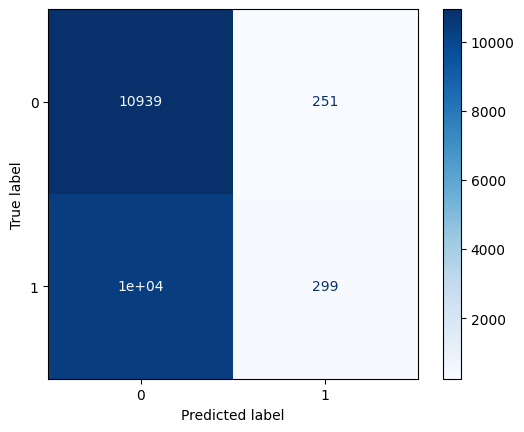

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_true, y_pred))
disp=ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues)